In [1]:
!cd

c:\Users\evanlee\Documents\GitHub\EvanPys\Progress\Hao_repcells_inv


In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import scanpy as sc
import sklearn
from scipy.sparse import csr_matrix
from sklearn.metrics.cluster import adjusted_rand_score
import copy


In [3]:
# os.chdir('/Users/evanli/Documents/Research_datasets/PBMC_Hao')
adata_raw = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\GSE164378\Hao_PBMC_GSE164378.h5ad")
# adata_raw = sc.read_h5ad('/home/jovyan/work/Research_datasets/GSE164378/Hao_PBMC_GSE164378.h5ad')
print(adata_raw.shape)  # row is cells, column is gene
# (161764, 20568)
# (161764, 33538)

(161764, 33538)


In [4]:
# CPM
# Total-count normalize the data matrix X to 10,000 reads per cell
# sc.pp.normalize_total(adata_raw, target_sum=1e6)

# Log
sc.pp.log1p(adata_raw)

In [5]:
# view adata.X
rows, cols = adata_raw.X[:5,:].nonzero()
i = 0
for row, col in zip(rows, cols):
    if i == 20: break
    print(f'Row {row}, Column {col}, Value {adata_raw.X[row, col]}')
    i += 1


Row 0, Column 12, Value 0.6931471824645996
Row 0, Column 43, Value 1.0986123085021973
Row 0, Column 48, Value 1.0986123085021973
Row 0, Column 53, Value 1.0986123085021973
Row 0, Column 55, Value 1.7917594909667969
Row 0, Column 66, Value 0.6931471824645996
Row 0, Column 77, Value 1.0986123085021973
Row 0, Column 78, Value 1.7917594909667969
Row 0, Column 89, Value 1.0986123085021973
Row 0, Column 93, Value 1.3862943649291992
Row 0, Column 102, Value 1.0986123085021973
Row 0, Column 154, Value 2.890371799468994
Row 0, Column 178, Value 1.0986123085021973
Row 0, Column 185, Value 0.6931471824645996
Row 0, Column 190, Value 0.6931471824645996
Row 0, Column 201, Value 2.1972246170043945
Row 0, Column 224, Value 1.0986123085021973
Row 0, Column 240, Value 0.6931471824645996
Row 0, Column 259, Value 0.6931471824645996
Row 0, Column 261, Value 1.945910096168518


In [6]:
# assuming data.X is your sparse CSR matrix
num_nonzero = adata_raw.X.getnnz(axis=1)  # number of nonzeros for each row
num_nonzero[:10]

array([2915, 1617, 1381, 1890, 1621, 1633, 2672, 1122, 1375, 1200],
      dtype=int64)

In [7]:
# All level 1 celltypes
types = np.unique(adata_raw.obs['celltype.l1']).tolist()
print(types)
# cell count in each celltype
adata_raw.obs['celltype.l1'].value_counts()

['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T']


celltype.l1
Mono       49010
CD4 T      41001
CD8 T      25469
NK         18664
B          13800
other T     6789
DC          3589
other       3442
Name: count, dtype: int64

## UMAP

In [8]:
# Delete the 'neighbors' key from adata.uns
# if 'neighbors' already exists in adata.uns, error would occurs at sc.pp.neighbors
if 'neighbors' in adata_raw.uns:
    del adata_raw.uns['neighbors']

In [9]:
# PCA
sc.tl.pca(adata_raw, svd_solver='arpack')

# Neighborhood graph
sc.pp.neighbors(adata_raw, n_neighbors=15, n_pcs=40)

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# create color palette for cell types
import seaborn as sns

palette = sns.color_palette('tab10', n_colors=len(types)+1)
del palette[7]
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)]

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


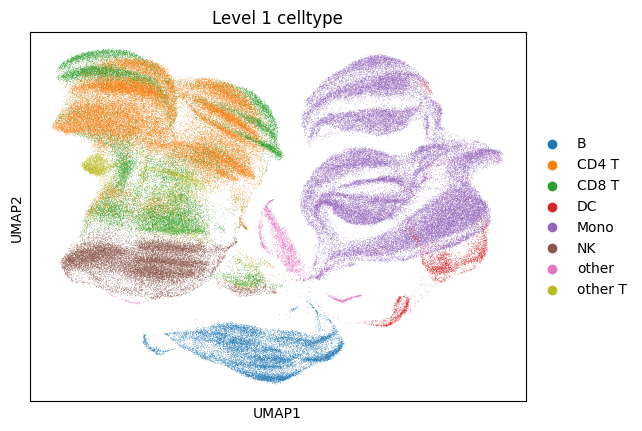

In [11]:
# UMAP

sc.tl.umap(adata_raw)
# sc.pl.umap(adata)
sc.pl.umap(adata_raw, color='celltype.l1', title='Level 1 celltype', palette=palette)

In [12]:
# Leiden clustering
sc.tl.leiden(adata_raw)

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


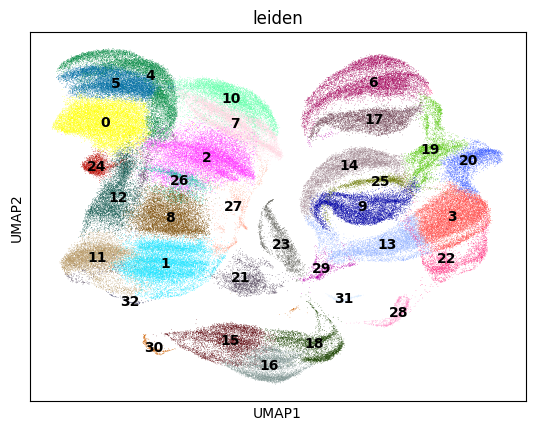

In [13]:
# Plot Leiden
sc.pl.umap(adata_raw, color='leiden', legend_loc="on data")

## Representative cells
Select top clustering coefficient cells in each cell type <br>
According to the inverse relationshiop between "celltype cell count" and "Percentage" <br>
Detailed in Excel file <br>

In [14]:
umap_adja_matrix = adata_raw.obsp['connectivities']
umap_adja_matrix

<161764x161764 sparse matrix of type '<class 'numpy.float32'>'
	with 3423620 stored elements in Compressed Sparse Row format>

In [15]:
# Clustering coefficient
import networkx as nx

G = nx.from_scipy_sparse_array(umap_adja_matrix)
print(G)

clustering_coeff = nx.clustering(G)
print(len(clustering_coeff))

Graph with 161764 nodes and 1711810 edges
161764


In [19]:
# Get the first 10 keys and values of the dictionary
first_10_items = list(clustering_coeff.items())[:10]

# Print the first 10 keys and values
for key, value in first_10_items:
    print(f"Key: {key}, Value: {value}")

Key: 0, Value: 0.2222222222222222
Key: 1, Value: 0.16993464052287582
Key: 2, Value: 0.15810276679841898
Key: 3, Value: 0.14210526315789473
Key: 4, Value: 0.18972332015810275
Key: 5, Value: 0.4152046783625731
Key: 6, Value: 0.3
Key: 7, Value: 0.24210526315789474
Key: 8, Value: 0.1383399209486166
Key: 9, Value: 0.19117647058823528


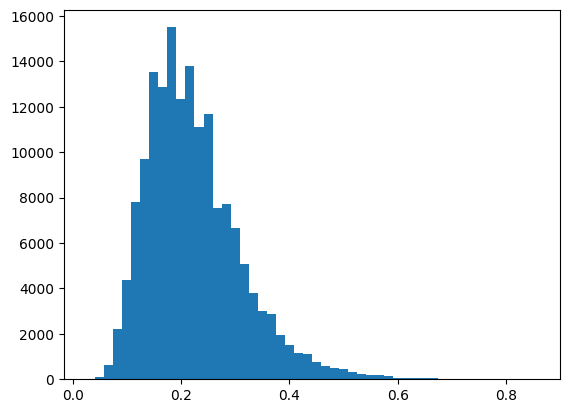

In [21]:
# Plot the distribution of clustering coefficients
import matplotlib.pyplot as plt
coefs = list(clustering_coeff.values())
plt.hist(coefs, bins=50)
plt.show()


In [23]:
# selection criteria
inv_percentage = pd.read_csv('L1_inverse_percentage.csv', index_col=0)
inv_percentage

,Original count,Percentage,Count
Mono,49010,0.200000,9802.000000
CD4_T,41001,0.340607,13965.245800
CD8_T,25469,0.613290,15619.883730
NK,18664,0.732760,13676.229490
B,13800,0.818153,11290.512640
other_T,6789,0.941239,6390.074737
DC,3589,0.997419,3579.737658
other,3442,1.000000,3442.000000


In [36]:
# Select top 20% clustering coefficient cells in each cell type
alltype_selected = dict()

for celltype in types:
    # get percentage
    percentage = inv_percentage.loc[celltype.replace(" ", "_"), 'Percentage']
    print(celltype, percentage)

    # select cells from one celltype
    celltype_idx = np.where(adata_raw.obs['celltype.l1'] == celltype)[0]
    celltype_coeff = {node_idx: clustering_coeff[node_idx] for node_idx in celltype_idx}
    
    top_count = int(len(celltype_coeff) * percentage)
    # print(top_count)
    top_indices = sorted(celltype_coeff, key=celltype_coeff.get, reverse=True)[:top_count]
    # print(top_indices)
    celltype_selected = {node_idx: celltype_coeff[node_idx] for node_idx in top_indices}
    # print(celltype_selected)
    alltype_selected.update(celltype_selected)
    print(celltype, len(celltype_selected))


B 0.81815309
B 11290
CD4 T 0.340607444
CD4 T 13965
CD8 T 0.613290028
CD8 T 15619
DC 0.997419242
DC 3579
Mono 0.2
Mono 9802
NK 0.732759831
NK 13676
other 1.0
other 3442
other T 0.941239466
other T 6390


In [37]:
len(alltype_selected)

77763

In [40]:
# add column to adata.obs
is_representative = ['Yes' if cell in alltype_selected.keys() else 'No' for cell in clustering_coeff.keys()]
is_representative = np.array(is_representative)

# Add is_representative (Yes or No) to data.obs
adata_raw.obs['is_representative'] = is_representative
adata_raw.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Phase,Batch,donor,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden,is_representative
L1_AAACCCAAGAAACTCA,Mono,CD14 Mono,CD14 Mono,G1,Batch1,P2,7535,217,10823,2915,3,No
L1_AAACCCAAGACATACA,CD4 T,CD4 TCM,CD4 TCM_1,G1,Batch1,P1,6013,209,5864,1617,0,No
L1_AAACCCACAACTGGTT,CD8 T,CD8 Naive,CD8 Naive,S,Batch1,P4,6620,213,5067,1381,5,No
L1_AAACCCACACGTACTA,NK,NK,NK_2,G1,Batch1,P3,3567,202,4786,1890,11,No
L1_AAACCCACAGCATACT,CD8 T,CD8 Naive,CD8 Naive,G1,Batch1,P4,6402,215,6505,1621,5,Yes


In [41]:
sum(adata_raw.obs['is_representative'] == 'Yes')

77763

In [42]:
# Add a column: Cluster_representative
# 在 representative cell 中，加上 cluster
clus_rep = []
for i in range(adata_raw.shape[0]):
    if adata_raw.obs['is_representative'][i] == 'Yes':
        # Yes_cluster_name
        clus_rep.append(adata_raw.obs['is_representative'][i] + '_' + adata_raw.obs['celltype.l1'][i])
    else:
        # No
        clus_rep.append(adata_raw.obs['is_representative'][i])

adata_raw.obs['cluster_representative'] = clus_rep

C:\Users\evanlee\AppData\Local\Temp\ipykernel_31132\4082106982.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata_raw.obs['is_representative'][i] == 'Yes':
C:\Users\evanlee\AppData\Local\Temp\ipykernel_31132\4082106982.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clus_rep.append(adata_raw.obs['is_representative'][i])
C:\Users\evanlee\AppData\Local\Temp\ipykernel_31132\4082106982.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `s

In [43]:
adata_raw.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Phase,Batch,donor,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden,is_representative,cluster_representative
L1_AAACCCAAGAAACTCA,Mono,CD14 Mono,CD14 Mono,G1,Batch1,P2,7535,217,10823,2915,3,No,No
L1_AAACCCAAGACATACA,CD4 T,CD4 TCM,CD4 TCM_1,G1,Batch1,P1,6013,209,5864,1617,0,No,No
L1_AAACCCACAACTGGTT,CD8 T,CD8 Naive,CD8 Naive,S,Batch1,P4,6620,213,5067,1381,5,No,No
L1_AAACCCACACGTACTA,NK,NK,NK_2,G1,Batch1,P3,3567,202,4786,1890,11,No,No
L1_AAACCCACAGCATACT,CD8 T,CD8 Naive,CD8 Naive,G1,Batch1,P4,6402,215,6505,1621,5,Yes,Yes_CD8 T


## Plot representative cell UMAP

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


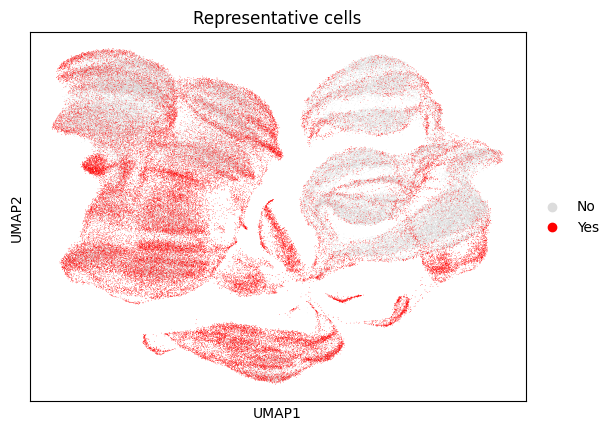

In [45]:
# Plot Yes/No representative cells
sc.pl.umap(adata_raw, color='is_representative', title='Representative cells', palette=['#dcdcdc', 'red'])

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


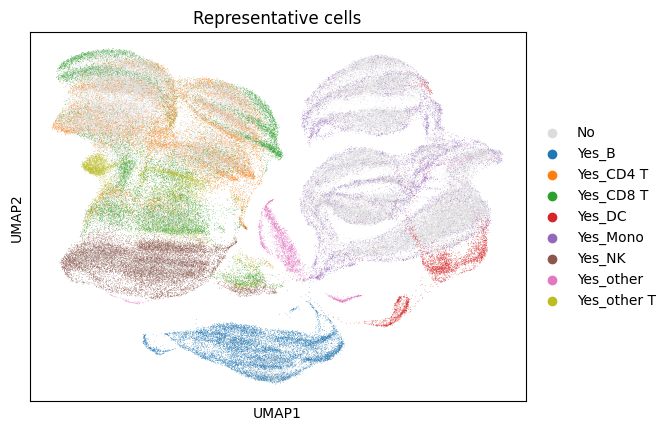

In [46]:
# Also differentiating representative cells from different cell types
sc.pl.umap(adata_raw, color='cluster_representative', title='Representative cells', palette=['#dcdcdc']+palette)

## Export representative cells adata

In [48]:
!cd

c:\Users\evanlee\Documents\GitHub\EvanPys\Progress\Hao_repcells_inv


In [49]:
adata_rep_cells = adata_raw[adata_raw.obs['is_representative'] == 'Yes']
adata_rep_cells.shape

(77763, 33538)

In [52]:
# replace level1 and level2 celltype names with new names
# replace " " with "_"

# level1
level1 = adata_rep_cells.obs['celltype.l1'].tolist()
level1 = [x.replace(" ", "_") for x in level1]
level1 = np.array(level1)
adata_rep_cells.obs['celltype.l1'] = level1

# level2
level2 = adata_rep_cells.obs['celltype.l2'].tolist()
level2 = [x.replace(" ", "_") for x in level2]
level2 = np.array(level2)
adata_rep_cells.obs['celltype.l2'] = level2


C:\Users\evanlee\AppData\Local\Temp\ipykernel_31132\1258106526.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_rep_cells.obs['celltype.l1'] = level1


In [54]:
adata_rep_cells.write_h5ad('Hao_level1_inv_rep_cells.h5ad')

In [55]:
np.unique(adata_rep_cells.obs['celltype.l1']).tolist()

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']

In [56]:
np.unique(adata_rep_cells.obs['celltype.l2']).tolist()

['ASDC',
 'B_intermediate',
 'B_memory',
 'B_naive',
 'CD14_Mono',
 'CD16_Mono',
 'CD4_CTL',
 'CD4_Naive',
 'CD4_Proliferating',
 'CD4_TCM',
 'CD4_TEM',
 'CD8_Naive',
 'CD8_Proliferating',
 'CD8_TCM',
 'CD8_TEM',
 'Doublet',
 'Eryth',
 'HSPC',
 'ILC',
 'MAIT',
 'NK',
 'NK_CD56bright',
 'NK_Proliferating',
 'Plasmablast',
 'Platelet',
 'Treg',
 'cDC1',
 'cDC2',
 'dnT',
 'gdT',
 'pDC']